parsing data

In [43]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import json
import os
import gzip  # Importato per la decompressione manuale gzip
import brotli  # Importato per la decompressione manuale Brotli


class VirtualSportsCollector:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.6',
            'Origin': 'https://www.eurobet.it',
            'Referer': 'https://www.eurobet.it/',
            'X-EB-Accept-Language': 'it_IT',
            'X-EB-MarketId': '5',
            'X-EB-PlatformId': '1',
            'Connection': 'keep-alive',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-site'
        }
        self.base_url = "https://virtualservice.eurobet.it/virtual-winning-service/virtual-schedule/services/winningresult/68/17/{}"
        self.csv_filename = "virtual_matches_data.csv"
        self.excel_filename = "virtual_matches_data.xlsx"

    def create_match_id(self, row):
        """Crea un identificatore univoco per ogni partita."""
        date_val = str(row.get('date', ''))
        hour_val = str(row.get('hour', ''))
        home_team_val = str(row.get('home_team', ''))
        away_team_val = str(row.get('away_team', ''))
        return f"{date_val}_{hour_val}_{home_team_val}_{away_team_val}"

    def load_existing_data(self):
        """Carica i dati esistenti dal CSV, se esiste."""
        if os.path.exists(self.csv_filename):
            try:
                dtype_spec = {  # Specifica dtype per colonne potenzialmente problematiche
                    'odds_1': 'object', 'result': 'object',
                    'over_under_25': 'object', 'odds_over_under_25': 'object',
                    'goal_no_goal': 'object', 'odds_goal_no_goal': 'object',
                    'home_goals': 'Int64', 'away_goals': 'Int64'  # Usa Int64 per permettere NaN interi
                }
                df = pd.read_csv(self.csv_filename, dtype=dtype_spec)
                if 'datetime' in df.columns:
                    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
                # Rimuovi colonne completamente vuote che potrebbero essere state create da errori precedenti
                df.dropna(axis=1, how='all', inplace=True)
                return df
            except pd.errors.EmptyDataError:
                print(f"Il file CSV {self.csv_filename} è vuoto. Verrà creato un nuovo DataFrame.")
                return pd.DataFrame()
            except Exception as e:
                print(f"Errore durante il caricamento del file CSV {self.csv_filename}: {e}")
                return pd.DataFrame()
        return pd.DataFrame()

    def get_virtual_data(self, start_date, end_date):
        """Recupera i dati virtuali per l'intervallo di date specificato."""
        all_matches = []
        current_date = start_date

        while current_date <= end_date:
            date_str = current_date.strftime("%d-%m-%Y")
            url = self.base_url.format(date_str)
            print(f"Tentativo di recupero dati per {date_str} da URL: {url}")
            data = None
            response = None

            try:
                response = requests.get(url, headers=self.headers, timeout=25)
                response.raise_for_status()

                if not response.content:
                    print(f"Risposta vuota ricevuta per {date_str} (Status: {response.status_code}). URL: {url}")
                    time.sleep(1.5)
                    current_date += timedelta(days=1)
                    continue

                try:
                    data = response.json()
                except json.JSONDecodeError:
                    print(f"Errore di decodifica JSON standard per {date_str}. Status: {response.status_code}")
                    content_encoding = response.headers.get('Content-Encoding', '').lower()
                    print(f"Header Content-Encoding: {content_encoding if content_encoding else 'Non presente'}")

                    decompressed_successfully = False
                    if content_encoding == 'br':
                        print("Tentativo di decompressione Brotli manuale.")
                        try:
                            decompressed_content = brotli.decompress(response.content)
                            data = json.loads(decompressed_content.decode('utf-8'))
                            print(f"Contenuto Brotli per {date_str} decompresso e parsato manualmente.")
                            decompressed_successfully = True
                        except Exception as e_decompress:
                            print(f"Fallimento decompressione/parsing Brotli per {date_str}: {e_decompress}")

                    elif content_encoding == 'gzip' or response.content.startswith(b'\x1f\x8b\x08'):
                        print("Tentativo di decompressione Gzip manuale.")
                        try:
                            decompressed_content = gzip.decompress(response.content)
                            data = json.loads(decompressed_content.decode('utf-8'))
                            print(f"Contenuto Gzip per {date_str} decompresso e parsato manualmente.")
                            decompressed_successfully = True
                        except Exception as e_decompress:
                            print(f"Fallimento decompressione/parsing Gzip per {date_str}: {e_decompress}")

                    if not decompressed_successfully:
                        print(f"Decodifica JSON fallita per {date_str} anche dopo tentativi manuali (se applicabili).")
                        print(f"Contenuto grezzo (primi 200 byte): {response.content[:200]}...")
                        time.sleep(1.5)
                        current_date += timedelta(days=1)
                        continue

                # Elaborazione dei dati
                if data and 'result' in data and data['result'] is not None and 'groupDate' in data['result']:
                    for group in data['result']['groupDate']:
                        if 'events' in group and group['events'] is not None:
                            for event in group['events']:
                                try:
                                    # --- Inizio Logica di Parsing Team Names Migliorata ---
                                    parsed_home_team = None
                                    parsed_away_team = None

                                    event_desc_raw = event.get('eventDescription')

                                    if isinstance(event_desc_raw, str) and event_desc_raw.strip():
                                        cleaned_desc = event_desc_raw.strip()
                                        parts = cleaned_desc.split(' - ', 1)  # Divide al massimo una volta

                                        if parts[0]:  # Nome squadra casa
                                            parsed_home_team = parts[0].strip()
                                            if not parsed_home_team:  # Se solo spazi
                                                parsed_home_team = None

                                        if len(parts) > 1:  # Se il separatore " - " è stato trovato
                                            if parts[1]:  # Nome squadra ospite
                                                parsed_away_team = parts[1].strip()
                                                if not parsed_away_team:  # Se solo spazi o stringa vuota
                                                    parsed_away_team = None
                                            # else: parsed_away_team rimane None (es. "Team A - ")
                                        # else: parsed_away_team rimane None (es. "Team A")
                                    elif event_desc_raw is not None:  # Se non è stringa ma esiste (improbabile per descrizione)
                                        temp_desc = str(event_desc_raw).strip()
                                        if temp_desc:
                                            parsed_home_team = temp_desc
                                    # --- Fine Logica di Parsing Team Names Migliorata ---

                                    match_data = {
                                        'date': event.get('date'),
                                        'hour': event.get('hour'),
                                        'home_team': parsed_home_team,  # Usa il nome parsato
                                        'away_team': parsed_away_team,  # Usa il nome parsato
                                        'score': event.get('finalResult'),
                                        'home_goals': None,
                                        'away_goals': None,
                                        'datetime': None
                                    }

                                    if event.get('date') and event.get('hour'):
                                        try:
                                            match_data['datetime'] = pd.to_datetime(f"{event['date']} {event['hour']}",
                                                                                    format='%d-%m-%Y %H:%M:%S',
                                                                                    errors='coerce')
                                        except ValueError as ve:
                                            print(
                                                f"Errore formato data/ora: {event.get('date')} {event.get('hour')}: {ve}")

                                    if event.get('finalResult') and '-' in event['finalResult']:
                                        try:
                                            scores = event['finalResult'].split('-')
                                            match_data['home_goals'] = int(scores[0])
                                            match_data['away_goals'] = int(scores[1])
                                        except ValueError:
                                            print(
                                                f"Score non parsabile: {event['finalResult']} per {event.get('eventDescription')}")

                                    if 'oddGroup' in event and event['oddGroup'] is not None:
                                        for odd_group in event['oddGroup']:
                                            bet_abbr = odd_group.get('betDescriptionAbbr')
                                            odds_list = odd_group.get('odds')
                                            result_desc_list = odd_group.get('resultDescription')

                                            if not (odds_list and result_desc_list): continue

                                            if bet_abbr == '1X2':
                                                match_data['odds_1'] = odds_list[0] if odds_list else None
                                                match_data['result'] = result_desc_list[0] if result_desc_list else None
                                            elif bet_abbr == 'Under / Over 2.5':
                                                match_data['over_under_25'] = result_desc_list[
                                                    0] if result_desc_list else None
                                                match_data['odds_over_under_25'] = odds_list[0] if odds_list else None
                                            elif bet_abbr == 'U/O 2.5':
                                                # print(f"Nota: Trovato 'U/O 2.5' (invece di 'Under / Over 2.5') per {date_str}, evento {event.get('eventDescription')}")
                                                match_data['over_under_25'] = result_desc_list[
                                                    0] if result_desc_list else None
                                                match_data['odds_over_under_25'] = odds_list[0] if odds_list else None
                                            elif bet_abbr == 'Goal/No Goal':
                                                match_data['goal_no_goal'] = result_desc_list[
                                                    0] if result_desc_list else None
                                                match_data['odds_goal_no_goal'] = odds_list[0] if odds_list else None

                                    all_matches.append(match_data)
                                except Exception as e_inner:
                                    print(
                                        f"Errore elaborazione evento ({date_str}): {e_inner}. Evento: {json.dumps(event, indent=2)}")
                        else:
                            print(f"Nessun evento ('events') in groupDate per {date_str}.")
                elif data:
                    print(f"Struttura JSON inattesa per {date_str}. Dati (inizio): {str(data)[:200]}...")
                else:
                    print(f"Nessun dato JSON valido per {date_str} dopo tentativi di decompressione.")

            except requests.exceptions.HTTPError as http_err:
                print(f"Errore HTTP per {date_str}: {http_err} (Status: {response.status_code if response else 'N/A'})")
            except requests.exceptions.ConnectionError as conn_err:
                print(f"Errore di connessione per {date_str}: {conn_err}")
            except requests.exceptions.Timeout as timeout_err:
                print(f"Timeout per {date_str}: {timeout_err}")
            except Exception as e:
                print(f"Errore imprevisto recupero dati ({date_str}): {e}")

            time.sleep(1.5)
            current_date += timedelta(days=1)

        return pd.DataFrame(all_matches)

    def merge_and_save_data(self, new_data):
        """Unisci i nuovi dati con quelli esistenti, rimuovi sempre i duplicati e salva."""
        existing_data = self.load_existing_data()

        if not existing_data.empty and 'datetime' in existing_data.columns:
            existing_data['datetime'] = pd.to_datetime(existing_data['datetime'], errors='coerce')
        if not new_data.empty and 'datetime' in new_data.columns:
            new_data['datetime'] = pd.to_datetime(new_data['datetime'], errors='coerce')

        if new_data.empty:
            print("Nessun nuovo dato da unire. Processando e risalvando i dati esistenti (se presenti).")
            if existing_data.empty:
                print("Database esistente è vuoto. Nessun dato da salvare o processare.")
                pd.DataFrame().to_csv(self.csv_filename, index=False)
                pd.DataFrame().to_excel(self.excel_filename, index=False)
                print(f"Creati/aggiornati file vuoti: {self.csv_filename} e {self.excel_filename}")
                return pd.DataFrame()
            combined_data = existing_data
        else:
            print(f"Unendo {len(new_data)} nuove partite con {len(existing_data)} partite esistenti.")
            combined_data = pd.concat([existing_data, new_data], ignore_index=True)

        if combined_data.empty:
            print("Nessun dato (né esistente né nuovo) da processare.")
            return pd.DataFrame()

        print(f"Dati combinati prima della pulizia: {len(combined_data)} righe.")

        if 'datetime' in combined_data.columns:
            initial_rows = len(combined_data)
            combined_data.dropna(subset=['datetime'], inplace=True)
            if len(combined_data) < initial_rows:
                print(f"Rimosse {initial_rows - len(combined_data)} righe con datetime non valido.")

        combined_data['match_id'] = combined_data.apply(self.create_match_id, axis=1)

        combined_data = combined_data[combined_data['match_id'] != "___"]
        combined_data.dropna(subset=['match_id'], inplace=True)

        if combined_data.empty:
            print("Nessun dato valido rimasto dopo la pulizia iniziale di match_id.")
            pd.DataFrame().to_csv(self.csv_filename, index=False)
            pd.DataFrame().to_excel(self.excel_filename, index=False)
            return pd.DataFrame()

        print(f"Dati prima della deduplicazione: {len(combined_data)} righe.")
        if 'datetime' in combined_data.columns and not combined_data.empty:
            combined_data = combined_data.sort_values('datetime', ascending=False)
            combined_data = combined_data.drop_duplicates(subset=['match_id'], keep='first')
        elif not combined_data.empty:
            combined_data = combined_data.drop_duplicates(subset=['match_id'], keep='first')
        print(f"Dati dopo la deduplicazione: {len(combined_data)} righe.")

        if 'match_id' in combined_data.columns:
            combined_data = combined_data.drop('match_id', axis=1)

        try:
            combined_data.to_csv(self.csv_filename, index=False)
            combined_data.to_excel(self.excel_filename, index=False)
            print(
                f"Dati salvati con successo ({len(combined_data)} righe) in {self.csv_filename} e {self.excel_filename}")
        except Exception as e:
            print(f"Errore durante il salvataggio dei file: {e}")

        return combined_data

    def collect_data(self, days_to_fetch_count=1):
        """Metodo principale per raccogliere, elaborare e salvare i dati."""
        if not isinstance(days_to_fetch_count, int) or days_to_fetch_count < 0:
            print("Errore: days_to_fetch_count deve essere un intero non negativo (0 per oggi, >0 per giorni passati).")
            return

        today = datetime.now()
        start_date_of_collection, end_date_of_collection = None, None

        if days_to_fetch_count == 0:
            start_date_of_collection = today
            end_date_of_collection = today
            print(f"Richiesta dati per oggi: {today.strftime('%d-%m-%Y')}")
        else:
            end_date_of_collection = today - timedelta(days=1)
            start_date_of_collection = end_date_of_collection - timedelta(days=days_to_fetch_count - 1)
            if days_to_fetch_count == 1:
                print(f"Richiesta dati per ieri: {end_date_of_collection.strftime('%d-%m-%Y')}")
            else:
                print(
                    f"Richiesta dati dal {start_date_of_collection.strftime('%d-%m-%Y')} al {end_date_of_collection.strftime('%d-%m-%Y')}")

        new_data = pd.DataFrame()
        if start_date_of_collection <= end_date_of_collection:
            new_data = self.get_virtual_data(start_date_of_collection, end_date_of_collection)
        else:
            print(
                f"Intervallo date non valido: start {start_date_of_collection}, end {end_date_of_collection}. Salto recupero dati.")

        if not new_data.empty:
            print(f"Recuperate {len(new_data)} nuove partite dalla fonte.")
        else:
            print("Nessun nuovo dato raccolto dalla fonte.")

        final_data = self.merge_and_save_data(new_data)

        if final_data is not None and not final_data.empty:
            print(f"Database finale contiene {len(final_data)} partite.")
        elif final_data is not None and final_data.empty:
            print("Il database finale è vuoto.")
        else:
            print("Errore: final_data è None dopo merge_and_save_data.")


def main(days_to_fetch_count=1):
    """Funzione principale per avviare il collettore di dati."""
    collector = VirtualSportsCollector()
    collector.collect_data(days_to_fetch_count)


if __name__ == "__main__":
    GIORNI_DA_RECUPERARE = 0

    print(f"Avvio script. GIORNI_DA_RECUPERARE impostato a: {GIORNI_DA_RECUPERARE}")
    main(days_to_fetch_count=GIORNI_DA_RECUPERARE)
    print("Script terminato.")


Avvio script. GIORNI_DA_RECUPERARE impostato a: 0
Richiesta dati per oggi: 15-05-2025
Tentativo di recupero dati per 15-05-2025 da URL: https://virtualservice.eurobet.it/virtual-winning-service/virtual-schedule/services/winningresult/68/17/15-05-2025
Recuperate 76 nuove partite dalla fonte.
Unendo 76 nuove partite con 30935 partite esistenti.
Dati combinati prima della pulizia: 31011 righe.
Dati prima della deduplicazione: 31011 righe.
Dati dopo la deduplicazione: 30939 righe.
Dati salvati con successo (30939 righe) in virtual_matches_data.csv e virtual_matches_data.xlsx
Database finale contiene 30939 partite.
Script terminato.


lettura df

In [44]:
data = pd.read_csv('virtual_matches_data.csv')

filtro per model data

In [45]:
data = data[['date', 'hour', 'home_team', 'away_team', 'home_goals', 'away_goals', 'result']]

In [46]:
data.to_csv('model_data.csv',index = False)

In [47]:
data.head(10)

,date,hour,home_team,away_team,home_goals,away_goals,result
0,15-05-2025,17:20:00,Colombia,Italia,2,0,1
1,15-05-2025,17:15:00,Argentina,Olanda,0,2,2
2,15-05-2025,17:10:00,Brasile,Francia,1,0,1
3,15-05-2025,17:05:00,Italia,Uruguay,1,2,2
4,15-05-2025,17:00:00,Spagna,Turchia,0,0,X
5,15-05-2025,16:55:00,Francia,Spagna,1,2,2
6,15-05-2025,16:50:00,Danimarca,Olanda,0,1,2
7,15-05-2025,16:45:00,Italia,Portogallo,0,1,2
8,15-05-2025,16:40:00,Germania,Messico,0,0,X
9,15-05-2025,16:34:00,Croazia,Inghilterra,1,2,2


Let's analyze the distribution of distances between draws (X results) and calculate cumulative percentage to understand the pattern of draws occurrence.

In [53]:
# Create is_draw column and calculate distances between draws
data['is_draw'] = data['result'] == 'X'
data['distance_to_next_draw'] = None

current_distance = 0
for i in range(len(data) - 1, -1, -1):
    if data.iloc[i]['is_draw']:
        current_distance = 0
    else:
        current_distance += 1
    data.loc[data.index[i], 'distance_to_next_draw'] = current_distance

Based on your request, I'll analyze the distances between non-draws (results different from 'X') and calculate their distribution in percentages.



In [54]:
# Calculate distances between non-draws (1 or 2 results)
data['is_non_draw'] = data['result'].isin(['1', '2'])
data['distance_between_non_draws'] = None

current_distance = 0
for i in range(len(data) - 1, -1, -1):
    if data.iloc[i]['is_non_draw']:
        current_distance = 0
    else:
        current_distance += 1
    data.loc[data.index[i], 'distance_between_non_draws'] = current_distance

Based on your request, I'll help analyze the distribution of non-draws between draws. Let's calculate the distribution and visualize it.



In [50]:
# Calculate distribution of non-draws between draws
non_draw_distances = data[data['is_draw'] == False]['distance_to_next_draw'].value_counts().sort_index()

# Calculate percentages and create a dataframe
total_matches = len(data)
dist_df = pd.DataFrame({
    'count': non_draw_distances,
    'percentage': non_draw_distances / total_matches * 100
})
dist_df['cumulative_percentage'] = dist_df['percentage'].cumsum()

print("Distribution of non-draws between draws:")
print(dist_df)

Distribution of non-draws between draws:
                       count  percentage  cumulative_percentage
distance_to_next_draw                                          
1                       6214   20.084683              20.084683
2                       4496   14.531821              34.616503
3                       3268   10.562720              45.179224
4                       2350    7.595591              52.774815
5                       1685    5.446201              58.221016
6                       1238    4.001422              62.222438
7                        896    2.896021              65.118459
8                        646    2.087980              67.206438
9                        471    1.522350              68.728789
10                       333    1.076311              69.805100
11                       235    0.759559              70.564659
12                       171    0.552700              71.117360
13                       135    0.436342              71.553702

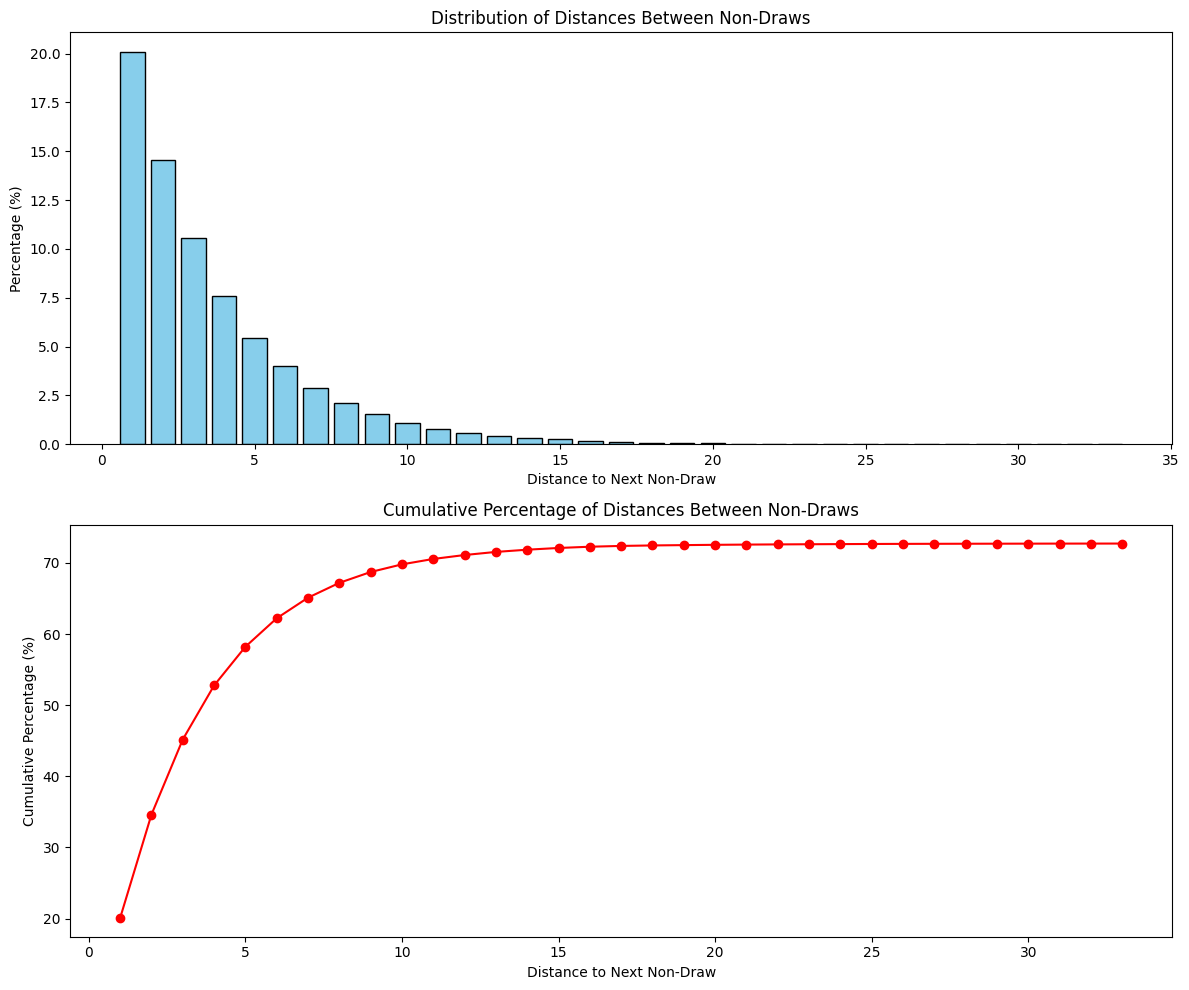

In [51]:
# Visualize the distribution
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Bar plot for distribution
ax1.bar(dist_df.index, dist_df['percentage'], color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Distances Between Non-Draws')
ax1.set_xlabel('Distance to Next Non-Draw')
ax1.set_ylabel('Percentage (%)')

# Line plot for cumulative distribution
ax2.plot(dist_df.index, dist_df['cumulative_percentage'], marker='o', color='red')
ax2.set_title('Cumulative Percentage of Distances Between Non-Draws')
ax2.set_xlabel('Distance to Next Non-Draw')
ax2.set_ylabel('Cumulative Percentage (%)')

plt.tight_layout()
plt.show()



This code will:
1. Calculate how many consecutive non-draws occur between draws
2. Create a distribution table showing the frequency and percentage of each sequence length
3. Visualize the distribution with a bar chart
4. Show the cumulative distribution with a line plot

The resulting plots will help understand the pattern of non-draws between draws in your dataset.


In [52]:
data.head(20)

,date,hour,home_team,away_team,home_goals,away_goals,result,is_draw,distance_to_next_draw,is_non_draw,distance_between_non_draws
0,15-05-2025,17:20:00,Colombia,Italia,2,0,1,False,4,True,0
1,15-05-2025,17:15:00,Argentina,Olanda,0,2,2,False,3,True,0
2,15-05-2025,17:10:00,Brasile,Francia,1,0,1,False,2,True,0
3,15-05-2025,17:05:00,Italia,Uruguay,1,2,2,False,1,True,0
4,15-05-2025,17:00:00,Spagna,Turchia,0,0,X,True,0,False,1
5,15-05-2025,16:55:00,Francia,Spagna,1,2,2,False,3,True,0
6,15-05-2025,16:50:00,Danimarca,Olanda,0,1,2,False,2,True,0
7,15-05-2025,16:45:00,Italia,Portogallo,0,1,2,False,1,True,0
8,15-05-2025,16:40:00,Germania,Messico,0,0,X,True,0,False,1
9,15-05-2025,16:34:00,Croazia,Inghilterra,1,2,2,False,6,True,0
